Loading and Plotting surface EMG Data
=====================================

Here we show how to load and visualize EMG data collected at the wrist as described in the paper ["A generic noninvasive neuromotor interface for human-computer interaction"](https://www.biorxiv.org/content/10.1101/2024.02.23.581779v1.full.pdf). We will show examples from each of the three tasks described in the paper: `discrete_gestures`, `handwriting`, and `wrist_pose`.

# Setup

First download the data, as described in the `README` (TODO) and set the `root_data_folder` below to the location of the files.

In [1]:
%load_ext autoreload
%autoreload 2


from neuromotor_data_loading.plot import plot_emg, plot_wrist
from neuromotor_data_loading.load import load_data
import matplotlib.pyplot as plt
import numpy as np
import glob
import os


root_data_folder = "/Users/rickwarren/Documents/emg_data/"


def get_task_files(root_data_folder: str, task: str):
    """Get all hdf5 files for a given task (discrete_gestures, handwriting, or wrist_pose)."""
    task_folder = os.path.join(root_data_folder, task)
    return glob.glob(os.path.join(task_folder, '*.hdf5'))

# Loading data

Next we'll select one of the `discrete_gesture` files.

In [2]:
file = get_task_files(root_data_folder, "discrete_gestures")[0]
print("Selected file:", os.path.basename(file))

Selected file: 2022-02-04-1643984526-combined-controls-dca-right@2-0958551f-a7ff-4e0d-bc0f-f838c0f8bd1f.hdf5


We'll load the file using the `load_data` utility function.

In [3]:
data = load_data(file)
data

The file contains EMG, timestamps, a task identifier, and a `labels` dataframe encoding the times of each gesture.

In [4]:
print("task:            ", data.task)
print("emg shape:       ", data.emg.shape)
print("timestamp shape: ", data.time.shape)
print("labels:          ")
data.labels

task:             discrete_gestures
emg shape:        (5406528, 16)
timestamp shape:  (5406528,)
labels:          


,name,time
0,index_press,1.643985e+09
1,index_release,1.643985e+09
2,index_press,1.643985e+09
3,index_release,1.643985e+09
4,index_press,1.643985e+09
...,...,...
1895,index_press,1.643987e+09
1896,index_release,1.643987e+09
1897,thumb_up,1.643987e+09
1898,middle_press,1.643987e+09


Data are similarly structured for the `handwriting` datasets. However, the dataframe now encodes the start and end times of each text prompt.

In [5]:
file = get_task_files(root_data_folder, "handwriting")[0]
data = load_data(file)

print("task:            ", data.task)
print("emg shape:       ", data.emg.shape)
print("timestamp shape: ", data.time.shape)
print("labels:          ")
data.labels

task:             handwriting
emg shape:        (984744, 16)
timestamp shape:  (984744,)
labels:          


,prompt,start,end
0,k,1.682709e+09,1.682709e+09
1,y,1.682709e+09,1.682709e+09
2,9,1.682709e+09,1.682709e+09
3,',1.682709e+09,1.682709e+09
4,h,1.682709e+09,1.682709e+09
...,...,...,...
91,"at least two no, thank you. not, not🤏",1.682709e+09,1.682709e+09
92,asl? ... i was poking fun at🤏,1.682709e+09,1.682709e+09
93,is there a metropolis you w←←←ould like me🤏,1.682709e+09,1.682709e+09
94,is→ there→ a→ specific→ event→ you're→ thinking🤏,1.682709e+09,1.682709e+09


The `wrist_pose` datasets do not have a `labels` dataframe. Instead, they have an additional stream of `wrist_angles` data.

In [6]:
file = get_task_files(root_data_folder, "wrist_pose")[0]
data = load_data(file)

print("task:               ", data.task)
print("emg shape:          ", data.emg.shape)
print("wrist_angles shape: ", data.wrist_angles.shape)
print("timestamp shape:    ", data.time.shape)

task:                wrist_pose
emg shape:           (3482132, 16)
wrist_angles shape:  (3482132, 3)
timestamp shape:     (3482132,)


# Plotting data

## Discrete Gestures

Here we plot EMG snippets for a single `discrete_gesture` dataset in 1 second windows centered on different gesture types.

Notice the use of `gesture_data.partition(start_time, end_time)` to extract windows of EMG around events of interest.

In [7]:
gesture_file = get_task_files(root_data_folder, "discrete_gestures")[0]
gesture_data = load_data(gesture_file)

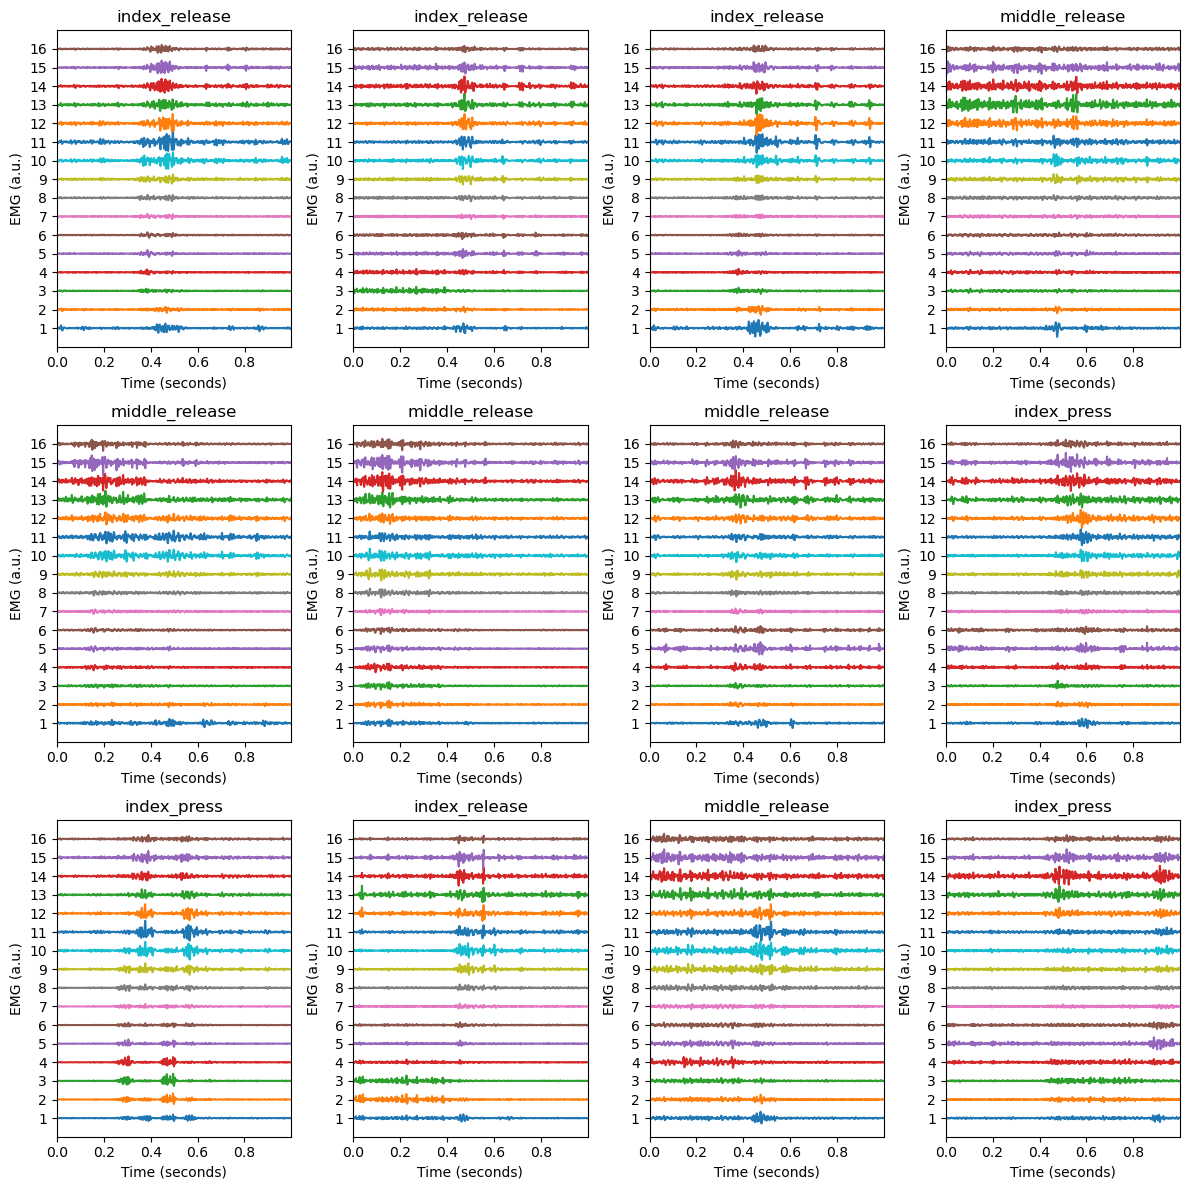

In [8]:
window = [-.5, .5]
nrows = 3
ncols = 4

fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 4))

# Sample random gestures
gestures = gesture_data.labels.sample(nrows * ncols, random_state=0, replace=False)

for ax, (_, gesture) in zip(axs.flatten(), gestures.iterrows()):
    timeseries = gesture_data.partition(gesture.time + window[0], gesture.time + window[1])
    plot_emg(timeseries["time"], timeseries["emg"], ax=ax)
    gesture_name = gesture.loc["name"]
    ax.set(title=f"{gesture_name}")

plt.tight_layout()

## Handwriting

Now we plot snippets of `handwriting` EMG corresponding to individual text prompts.

In [9]:
handwriting_file = get_task_files(root_data_folder, "handwriting")[0]
handwriting_data = load_data(handwriting_file)

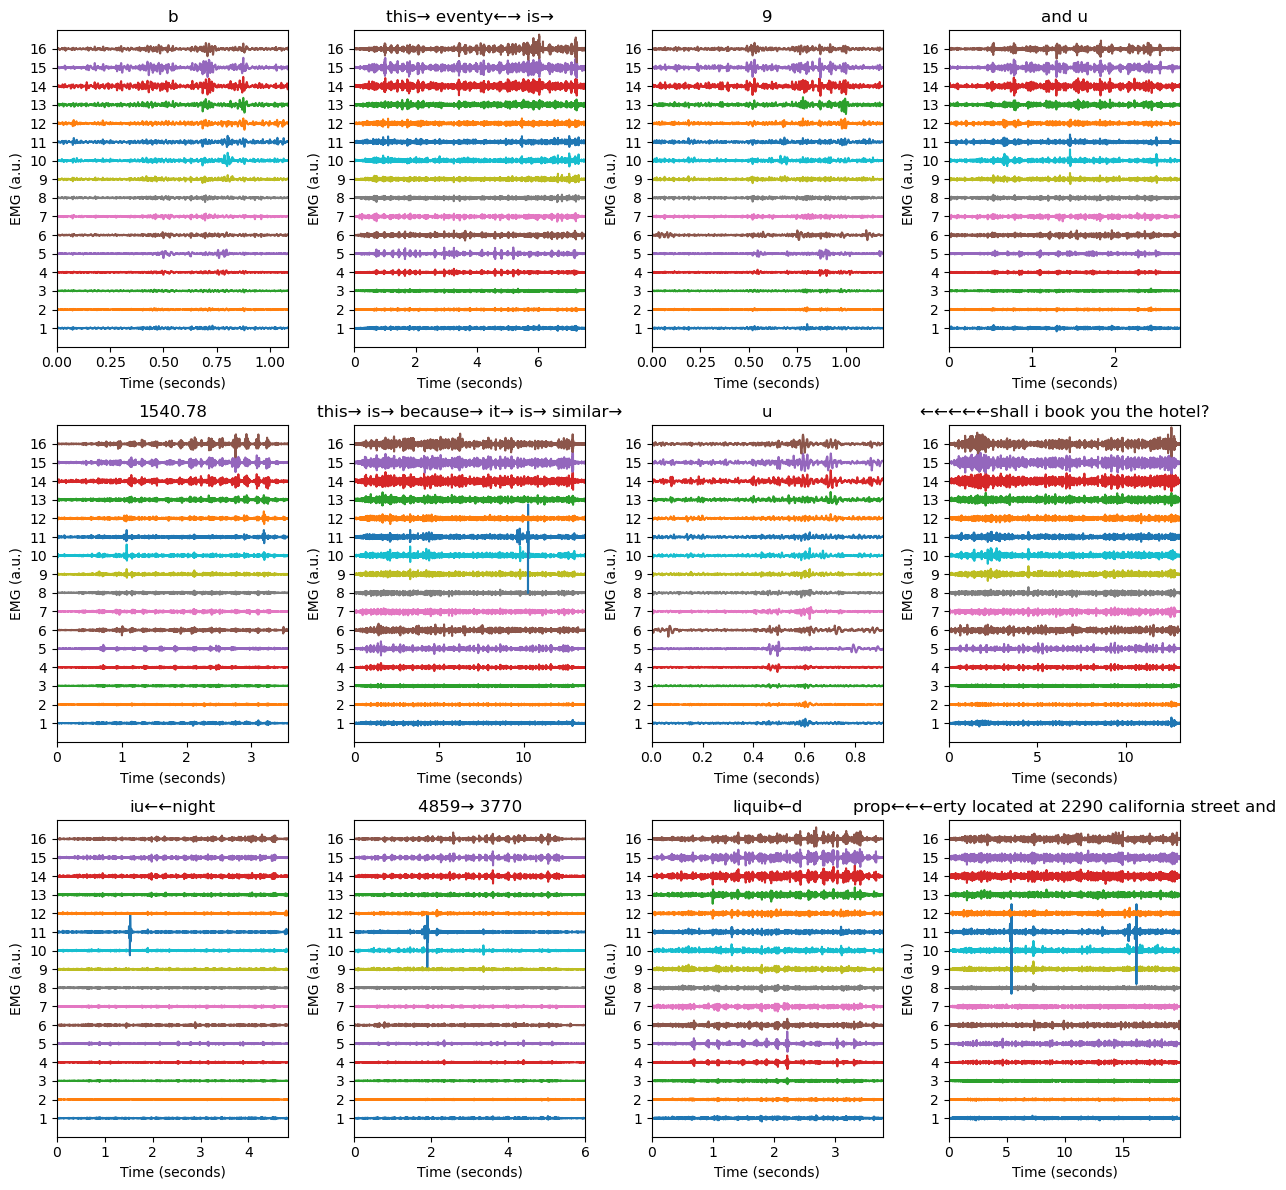

In [10]:
nrows = 3
ncols = 4

fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 4))

# Sample random prompts
prompts = handwriting_data.labels.sample(nrows * ncols, random_state=0, replace=False)

for ax, (_, prompt) in zip(axs.flatten(), prompts.iterrows()):
    timeseries = handwriting_data.partition(prompt.start, prompt.end)
    plot_emg(timeseries["time"], timeseries["emg"], ax=ax)
    ax.set(title=f"{prompt.prompt}")

plt.tight_layout()

## Wrist pose

Finally, we'll plot EMG and wrist angles side-by-side for a few example `wrist_pose` datasets.

In [11]:
wrist_files = get_task_files(root_data_folder, "wrist_pose")

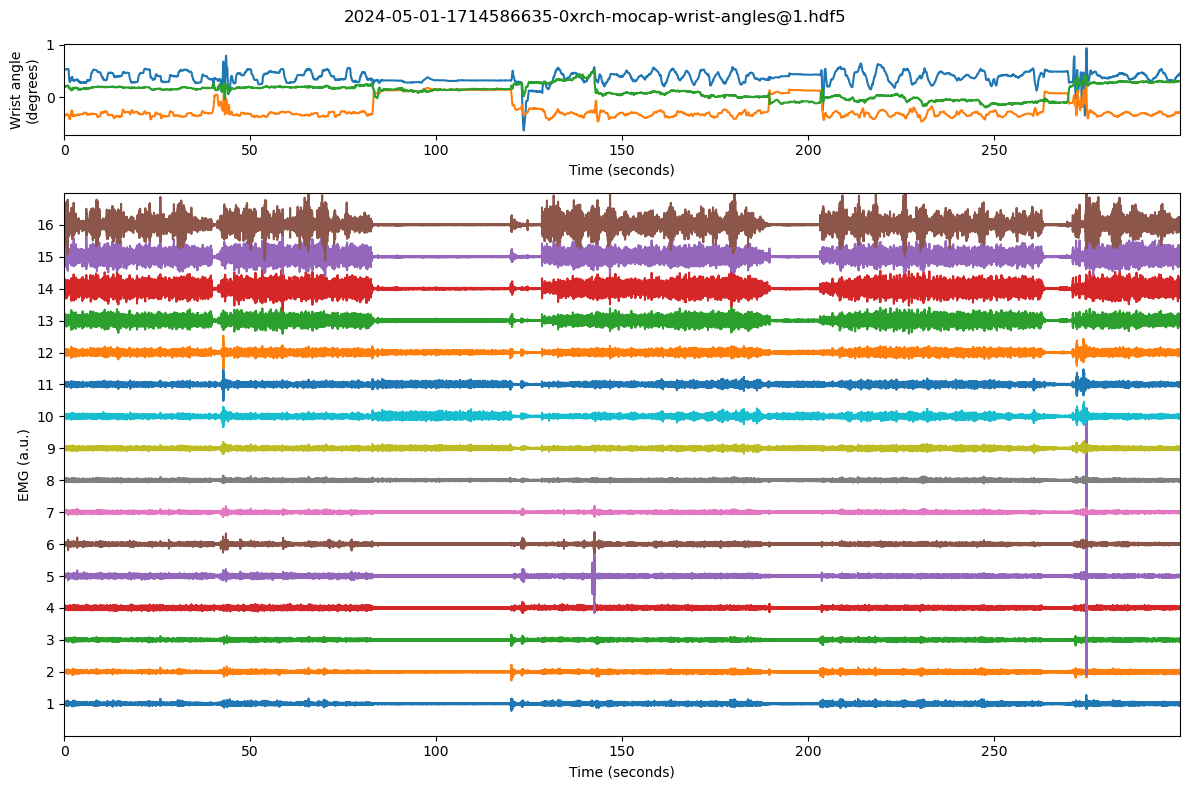

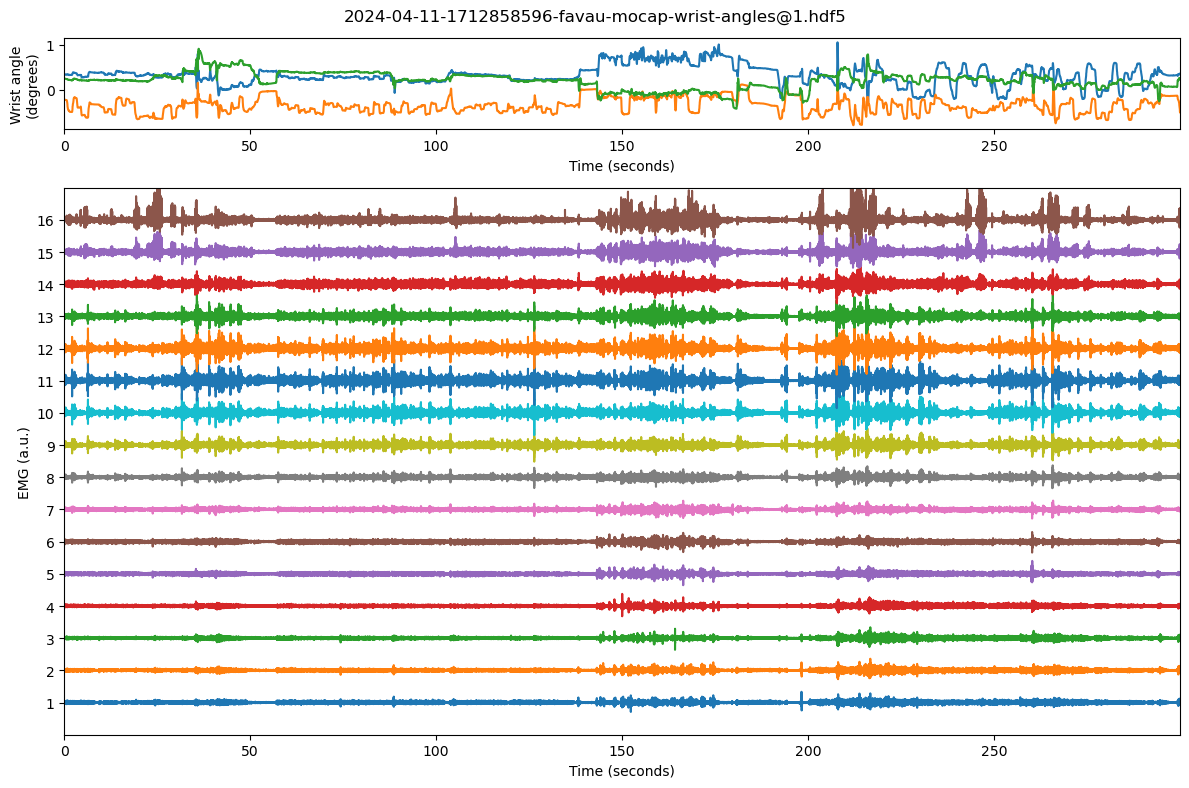

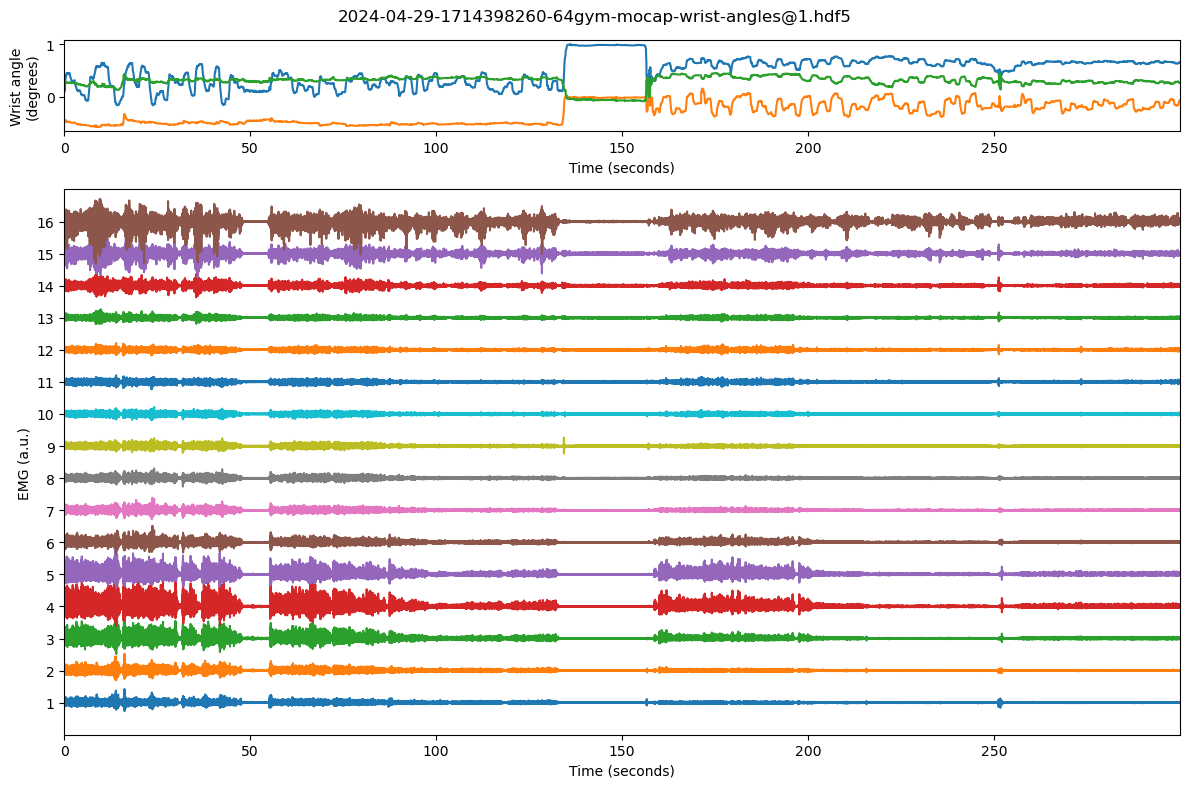

In [12]:
num_examples = 3
duration = 60 * 5  # Seconds

rng = np.random.default_rng(0)

for wrist_file in wrist_files[:num_examples]:
    fig, axs = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={"height_ratios": [1, 6]})
    
    # Load wrist data
    wrist_data = load_data(wrist_file)
    
    # Select a random starting point
    start_t = rng.choice(wrist_data.time[wrist_data.time < (wrist_data.time[-1] - duration)])
    timeseries = wrist_data.partition(start_t, start_t + duration)
    
    plot_wrist(timeseries["time"], timeseries["wrist_angles"], ax=axs[0])
    plot_emg(timeseries["time"], timeseries["emg"], ax=axs[1])

    fig.suptitle(os.path.basename(wrist_file))
    plt.tight_layout()